# Imu Data

This notebook demonstrates how to read the IMU-Data of the Arduino from serial and shows the data-makeup, already pointing out some flaws.

In [1]:
import serial
import struct
import matplotlib.pyplot as plt
import numpy as np
import time
np.set_printoptions(suppress=True)


This data is intended for mean calibration so put the imu in upright position and do not move it while the loop is executing.  
Just interrupt the following while true loop if you have gathered enough data.

In [10]:
readings = []
last_time = time.time()
with serial.Serial('COM9', 9600) as arduino_ser: 
    while True:
        data = arduino_ser.read(36)  # 9 floats -> 4 bytes per float -> 36
        
        reading = struct.unpack('fffffffff', data)
        readings.append(np.array(reading))

        current_time = time.time()
        time_interval = current_time - last_time
        sample_rate = 1 / time_interval

        last_time = current_time
        time.sleep(0.005) # 1/samplerate (around here 200 for demonstration purposes)


KeyboardInterrupt: 

In [11]:

np.save('imu_readings_calib.npy', np.array(readings))

### Start from here if you do not want to gather data yourself

In [4]:
readings = np.load('imu_readings_calib.npy')

In [12]:
print(len(readings))

1388


### Function to plot the IMU-data by type
(I do not want to write the whole plot stuff over and over and over again)

In [5]:
def visualize_single_data(readings, type = 'a'):
    plt.figure(figsize=(10, 6))
    if type == 'a':
        x_values = [reading[0] for reading in readings]
        y_values = [reading[1]for reading in readings]
        z_values = [reading[2] for reading in readings]
        plt.ylabel('Acceleration (m/s^2)')
        plt.title('Accelerometer Data')
    elif type == 'g':
        x_values = [reading[3] for reading in readings]
        y_values = [reading[4] for reading in readings]
        z_values = [reading[5] for reading in readings]
        plt.ylabel('Angular Velocity (rad/s)')
        plt.title('Gyroscope Data')
    elif type == 'm':
        x_values = [reading[6] for reading in readings]
        y_values = [reading[7] for reading in readings]
        z_values = [reading[8] for reading in readings]
        plt.ylabel('Magnetic Field (uT)')
        plt.title('Magnetometer Data')
    
    plt.plot(x_values, label='x')
    plt.plot(y_values, label='y')
    plt.plot(z_values, label='z')
    plt.xlabel('Time')
    
    plt.legend()
    #plt.savefig(f'./plots/calibration_{type}.png')
    plt.show()

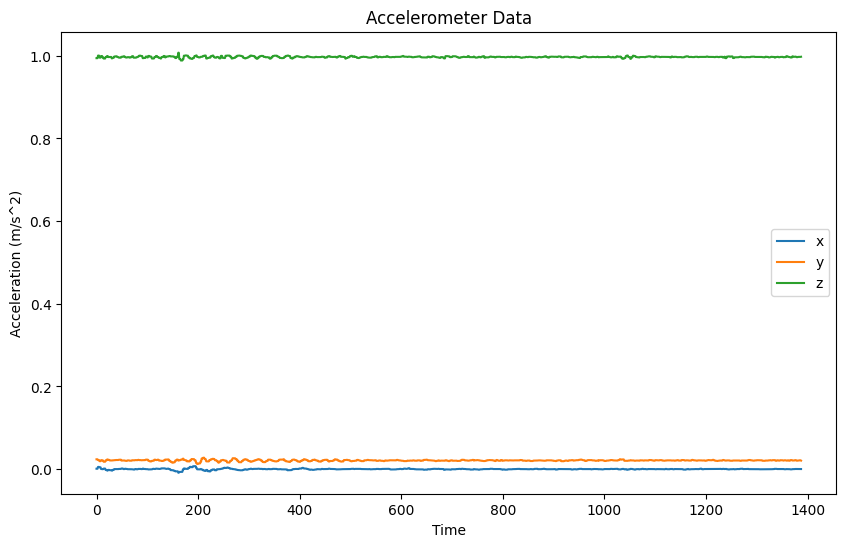

In [6]:
visualize_single_data(readings, type='a')

The z-accel values should be exactly 1 and it seems to be okay in this plot, however one can already see that at least the y value has a significant offset from 0.

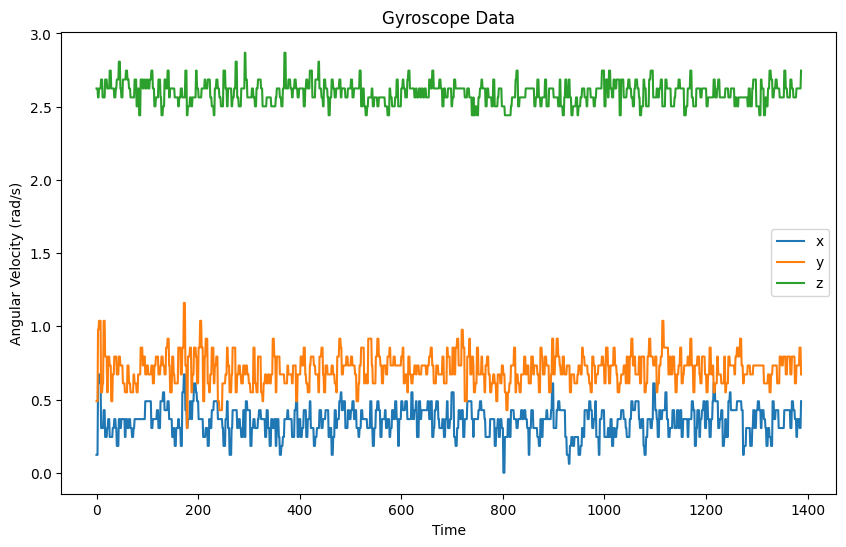

In [7]:
visualize_single_data(readings, type='g')

In the gyro data, it is even more apparent. The z-rotation (yaw) has a drift of over 2.5 deg/second. Over a minute that means 150 degrees of drift which is super substantial.

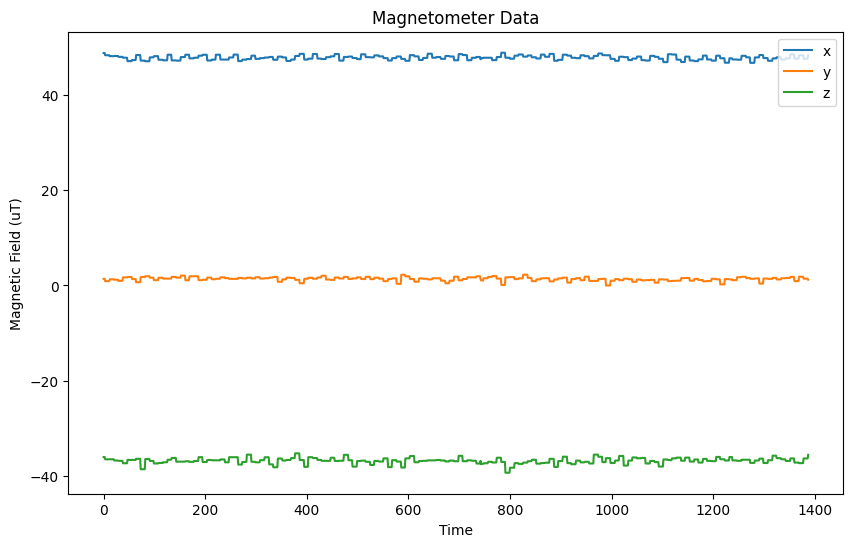

In [8]:
visualize_single_data(readings, type = 'm')

The magnetometer data is not as easily interpreted, as the lines depend on the current orientation of the imu.

## The most Basic calibration of all

Since there is static error in accelerometer and gyro, let's subtract the mean. This gets rid of most of the drift.

In [9]:
mean_drifts = np.mean(np.array(readings)[:,:6], axis = 0) # magnetometer drift is not as easily calibratable
mean_drifts

array([-0.00002647,  0.02097068,  0.99711508,  0.35587718,  0.70898402,
        2.59496156])

In [10]:
calib_readings_list = [reading[:6] - mean_drifts for reading in readings]
calib_readings = np.array(calib_readings_list)
calib_readings[:,2] +=1

In [11]:
calib_readings

array([[ 0.00100303,  0.00283303,  0.99714762, -0.23380686, -0.22070277,
         0.02955016],
       [ 0.00100303,  0.00283303,  0.99714762, -0.23380686, -0.22070277,
         0.02955016],
       [ 0.00100303,  0.00283303,  0.99714762, -0.23380686, -0.22070277,
         0.02955016],
       ...,
       [ 0.00027061,  0.00039163,  1.00032145, -0.05070139,  0.14550816,
         0.02955016],
       [ 0.00027061,  0.00039163,  1.00032145, -0.05070139,  0.14550816,
         0.02955016],
       [ 0.00027061, -0.00034079,  1.00056559,  0.13240407, -0.0375973 ,
         0.15162047]])

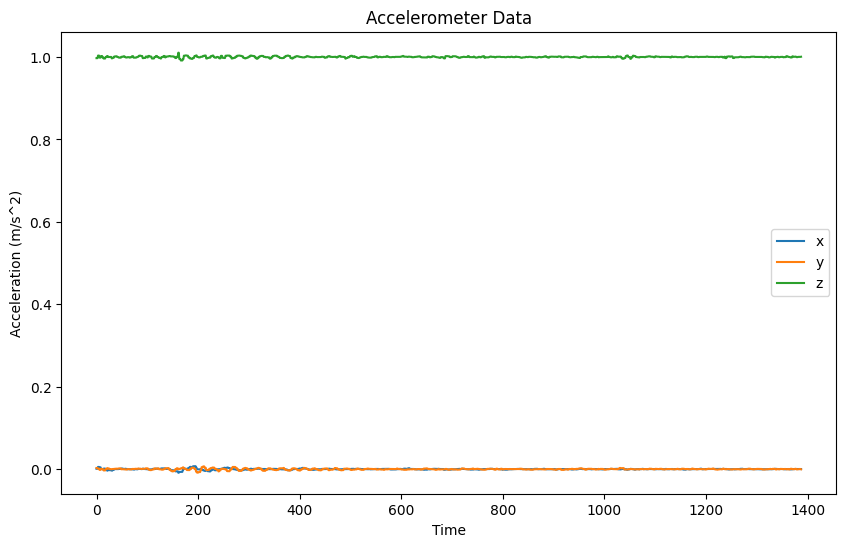

In [12]:
visualize_single_data(calib_readings, 'a')

waaay better. The lines are closer to where they should be now.

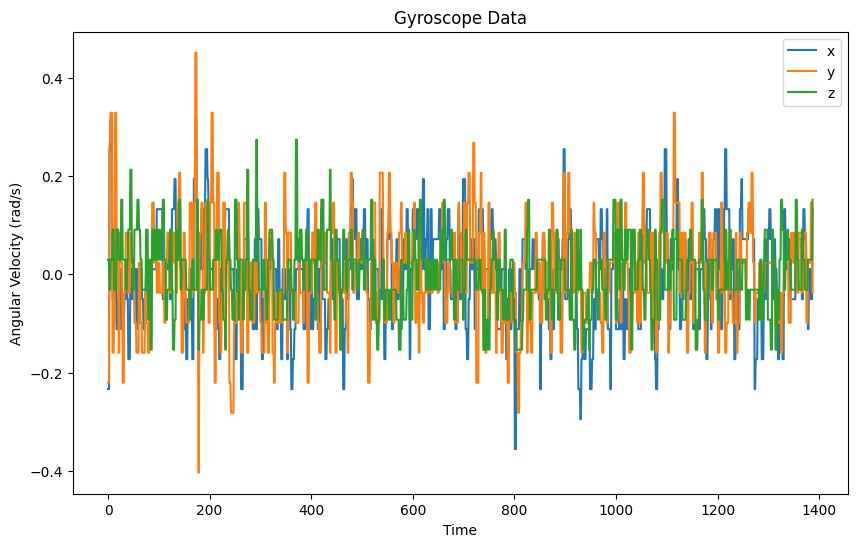

In [13]:
visualize_single_data(calib_readings, 'g')

If you look at the scale of the y axis, it is pretty clear that there has been a good improvement.

In [ ]:
calibration_vector = mean_drifts.copy()
calibration_vector[2] -=1